## Portfolio optimization

For this project, seven companies from diverse economical sectors have been selected to create two potentially profitable investment portfolios. One that is lower risk and one that is higher risk. 

Optimization via Monte Carlo Simulation was performed subject to constrains that (A) minimize risk, and (B) allow a better risk-adjustement.

#### Preliminary definitions

Calculations are based on the following definitions:

* Expected return:

  $$\mu_V = \mathbf{m} \mathbf{w}^T$$
  
  
* Volatility:
  $$\sigma_V = \sqrt{\mathbf{w}\mathbf{C}\mathbf{w}^{T}}$$

* Sharpe ratio:
  $$S_r = \frac{\mu_V - r}{\sigma_V}$$


  where

  $$\mathbf{w} = [w_1, w_2, \cdots, w_N]$$ 

  $$\mathbf{m} = [\mu_1, \mu_2, \cdots, \mu_N]$$

  $$\mathbf{C} = \begin{bmatrix}
c_{11}&c_{12} & \cdots & c_{1N} \\
c_{21}&c_{22} & \cdots & c_{2N} \\
\vdots & \vdots & \ddots & \vdots \\
c_{N1}&c_{N2} & \cdots & c_{NN}
\end{bmatrix} $$

$$c_{ij} = Cov(K_i, K_j)$$

$\mathbf{w}$ (portfolio weights vector)

$\mathbf{m}$ (expected return assets vector)

$K_i$ (return value for the asset $i$)

$r$ (Risk free rate)

### Part 0. Setting required packages and functions for analyses

In [1]:
#Import Packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
import yfinance as yf
import numpy.random as npr
import math
import seaborn as sns
npr.seed(42)

image_save_dpi = 1200
image_format = "pdf"

In [2]:
# required functions
def calculate_var_95(portfolio_returns):
    """
    # Function developed by Thomas Polstra
    Calculate the Value at Risk (VaR) at the 95% confidence interval for a given portfolio.

    Parameters:
    portfolio_returns (numpy array): An array of portfolio returns.

    Returns:
    float: The VaR at the 95% confidence level expressed as a percentage.
    """
    # Sort the portfolio returns in ascending order
    sorted_returns = np.sort(portfolio_returns)

    # Determine the number of data points
    N = len(sorted_returns)

    # Calculate the index corresponding to the 5th percentile (95% confidence level)
    percentile_index = int(0.05 * N)

    # Find the return value at the 5th percentile
    var_95 = sorted_returns[percentile_index]

    # Express VaR as a percentage by multiplying it by 100
    var_95_percent = var_95 * 100

    return var_95_percent

def portfolio_variance(weights, covariance_matrix):
    """
    Calculate the variance of a given portfolio.
    
    Parameters: 
    covariance_matrix (numpy array): An array of the covariance matrix

    Returns:
    float: The computed variance
    """
    sigma_V_2 = np.matmul(np.array(np.matmul(weights, covariance_matrix)), weights[:, np.newaxis]) 
    return np.squeeze(sigma_V_2)

def portfolio_expected_return(weights, daily_returns, tickers):
    """
    Calculate the expected return of a given portfolio.
    
    Parameters: 
    weights (): An array of the covariance matrix
    daily_returns ():
    tickers ():

    Returns:
    float: The computed expected return
    """
    m = np.array([daily_returns[stock].mean() for stock in tickers])
    m_V = np.matmul(m*252, weights[:, np.newaxis])
    return np.squeeze(m_V) 

def returns(daily_returns, tickers, weights):
    """
    Calculate portfolio returns.
    
    Parameters: 
    weights (): 
    daily_returns ():
    tickers ():

    Returns:
    float: The computed returns
    """
    asset_returns_array = np.array([daily_returns[stock] for stock in tickers])
    optimal_weights_transposed = weights[:, np.newaxis]
    portfolio_returns = np.sum(asset_returns_array*optimal_weights_transposed, axis = 0)
    return portfolio_returns

def sharpe_ratio(mu_v, sigma_v, risk_free_rate):
    return ((mu_v - risk_free_rate)/sigma_v)

### Part 1: Download stocks data and data exploration

In [3]:
names_companies = ['Fast Retailing Co., Ltd.','Alphabet Inc.','International Business Machines Corporation','JPMorgan Chase & Co.','Netflix, Inc.','Exxon Mobil Corporation','Yum! Brands, Inc.' ]
tickers = ['FRCOY', 'GOOG', 'IBM', 'JPM', 'NFLX', 'XOM', 'YUM']

end_date = '2025-06-25'
start_date = pd.to_datetime(end_date) - dt.timedelta(days = 2*365)

stock = yf.download(tickers, start = start_date, end = end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed


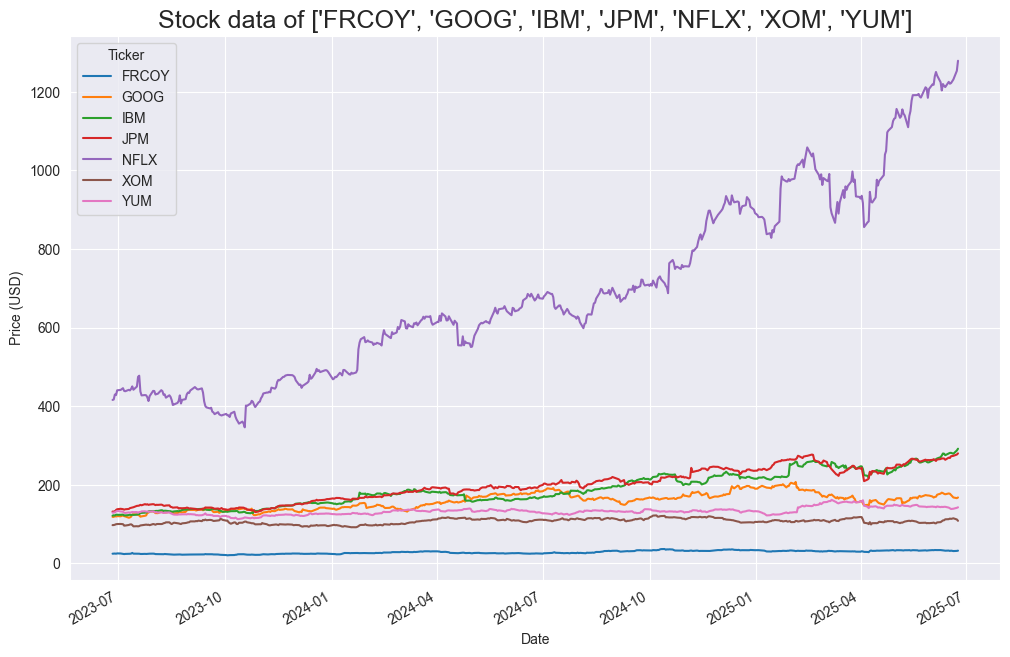

In [4]:
#Plot Closing Price stock data
image_name = "source_reports/images/figure_0_project_1"

stock['Close'][tickers].plot(figsize = (12,8))
plt.title(f'Stock data of {tickers}', size = 18)
plt.ylabel('Price (USD)')
#plt.savefig(image_name, format = image_format, dpi = image_save_dpi)
plt.show()


In [5]:
#Add in column that is cumulative returns of the stocks

# Step 1: Compute cumulative return from 'Close' prices
close = stock['Close']
normalized_returns = close/close.iloc[0]-1

# Step 2: Create MultiIndex columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

In [6]:
stock

Close                                                   \
Ticker          FRCOY        GOOG         IBM         JPM         NFLX   
Date                                                                     
2023-06-26  24.642990  118.386292  121.455414  131.887238   415.940002   
2023-06-27  24.751898  118.306770  122.380142  131.896683   417.079987   
2023-06-28  25.009319  120.364532  121.843796  131.318726   429.839996   
2023-06-29  24.623190  119.300858  123.970711  135.904785   428.239990   
2023-06-30  25.375647  120.255188  123.739517  137.809326   440.489990   
...               ...         ...         ...         ...          ...   
2025-06-17  31.709999  177.229996  281.149109  268.227753  1220.670044   
2025-06-18  32.410000  173.979996  281.308044  272.646484  1222.290039   
2025-06-20  31.330000  167.729996  279.083099  273.681488  1231.410034   
2025-06-23  31.780001  166.009995  287.237946  276.935822  1253.540039   
2025-06-24  32.369999  167.740005  291.816986  279.911499  1279.109985   

                                         High                          ...  \
Ticker             XOM         YUM      FRCOY        GOOG         IBM  ...   
Date                                                                   ...   
2023-06-26   97.348106  129.133759  25.068723  121.994847  121.520152  ...   
2023-06-27   97.590790  129.181870  24.860807  119.186535  122.944234  ...   
2023-06-28   98.384209  130.028473  25.187533  120.553405  122.222943  ...   
2023-06-29   99.597672  132.048721  24.751899  120.195541  124.238893  ...   
2023-06-30  100.111069  133.289764  25.385548  121.308922  124.867702  ...   
...                ...         ...        ...         ...         ...  ...   
2025-06-17  114.000000  139.990005  32.009998  178.714996  282.877444  ...   
2025-06-18  113.190002  138.360001  32.639999  177.824005  284.983209  ...   
2025-06-20  114.699997  139.059998  32.060001  175.365005  282.211939  ...   
2025-06-23  111.739998  141.389999  31.780001  168.479996  287.635253  ...   
2025-06-24  108.339996  142.699997  32.490002  169.250000  292.363280  ...   

             Volume                    Cumulative Return                      \
Ticker         NFLX       XOM      YUM             FRCOY      GOOG       IBM   
Date                                                                           
2023-06-26  4640000  14283400  1486300          0.000000  0.000000  0.000000   
2023-06-27  4818100  13227500  1593100          0.004419 -0.000672  0.007614   
2023-06-28  8811300  13084100  1174600          0.014865  0.016710  0.003198   
2023-06-29  4932300  11364400  1525200         -0.000803  0.007725  0.020710   
2023-06-30  7346400  13544700  1391800          0.029731  0.015786  0.018806   
...             ...       ...      ...               ...       ...       ...   
2025-06-17  1892100  19451700  1892900          0.286776  0.497048  1.314834   
2025-06-18  2281000  17968900  1539500          0.315181  0.469596  1.316142   
2025-06-20  5348200  36273300  2956500          0.271355  0.416803  1.297823   
2025-06-23  2667300  26631100  1955800          0.289616  0.402274  1.364966   
2025-06-24  2663300  24828300  1629100          0.313558  0.416887  1.402668   

                                                    
Ticker           JPM      NFLX       XOM       YUM  
Date                                                
2023-06-26  0.000000  0.000000  0.000000  0.000000  
2023-06-27  0.000072  0.002741  0.002493  0.000373  
2023-06-28 -0.004311  0.033418  0.010643  0.006929  
2023-06-29  0.030462  0.029572  0.023108  0.022573  
2023-06-30  0.044903  0.059023  0.028382  0.032184  
...              ...       ...       ...       ...  
2025-06-17  1.033766  1.934726  0.171055  0.084070  
2025-06-18  1.067270  1.938621  0.162735  0.071447  
2025-06-20  1.075117  1.960547  0.178246  0.076868  
2025-06-23  1.099792  2.013752  0.147839  0.094911  
2025-06-24  1.122355  2.075227  0.112913  0.105056  

[501 rows x 42 columns

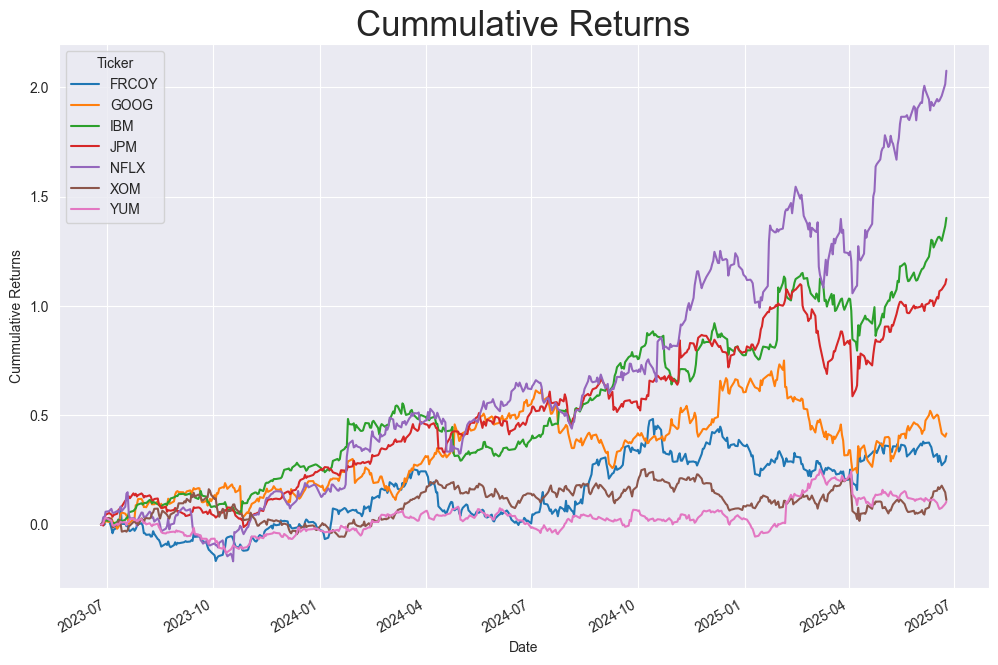

In [7]:
#Plot Cumlative Returns together
stock['Cumulative Return'][tickers].plot(figsize = (12,8))
plt.title(f'Cummulative Returns', size = 25)
plt.ylabel('Cummulative Returns')
image_name = "source_reports/images/figure_1_project_1"

plot_margin = 0.01

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))

#plt.savefig(image_name, format=image_format, dpi=image_save_dpi)
plt.show()

First, I calculate the daily returns for all the candidate companies. 

In [8]:
log_daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
log_daily_returns = log_daily_returns.dropna()

By simplicity, the following analyses will be performed over a time interval that shows significant normality (p-value = 0.0771, See Miniproject 2). The time period starts from 2023.07.12 to 2024.08.05, and has length of 269 days. 

In [9]:
log_daily_returns = log_daily_returns.iloc[9:278,:]

In [10]:
log_daily_returns

Ticker,FRCOY,GOOG,IBM,JPM,NFLX,XOM,YUM
Date,,,,,,,
2023-07-11,0.006091,0.007162,0.011521,0.015518,-0.003402,0.012153,-0.004759
2023-07-12,0.017657,0.016096,-0.011973,0.004940,0.008685,0.004895,0.006908
2023-07-13,0.065806,0.042633,0.008097,0.004848,0.014155,-0.018481,0.006272
2023-07-14,-0.072190,0.006945,-0.003890,0.006027,-0.018985,-0.035044,-0.002873
2023-07-17,-0.000400,-0.005105,0.006277,0.023818,0.018252,0.004350,0.001327
...,...,...,...,...,...,...,...
2024-07-29,-0.010088,0.014420,-0.001305,-0.006571,-0.007009,-0.010538,0.018416
2024-07-30,-0.008674,0.004257,-0.002405,0.020374,-0.007011,0.017672,0.013252
2024-07-31,0.044452,0.007478,0.005742,-0.011169,0.009225,0.003548,0.004981


The expected log return in annualized form for the individual portfolio assets is

In [11]:
log_daily_returns.mean()*252

Ticker
FRCOY    0.090500
GOOG     0.343261
IBM      0.369529
JPM      0.319526
NFLX     0.307979
XOM      0.135603
YUM      0.020636
dtype: float64

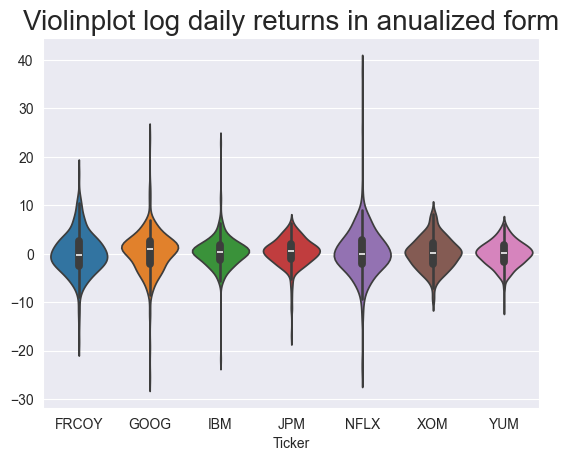

In [12]:
image_name = "source_reports/images/figure_1b_project_1"

sns.violinplot( data=log_daily_returns*252, order=tickers)
plt.title('Violinplot log daily returns in anualized form', size=20)
#plt.savefig(image_name, format=image_format, dpi=image_save_dpi)

plt.show()

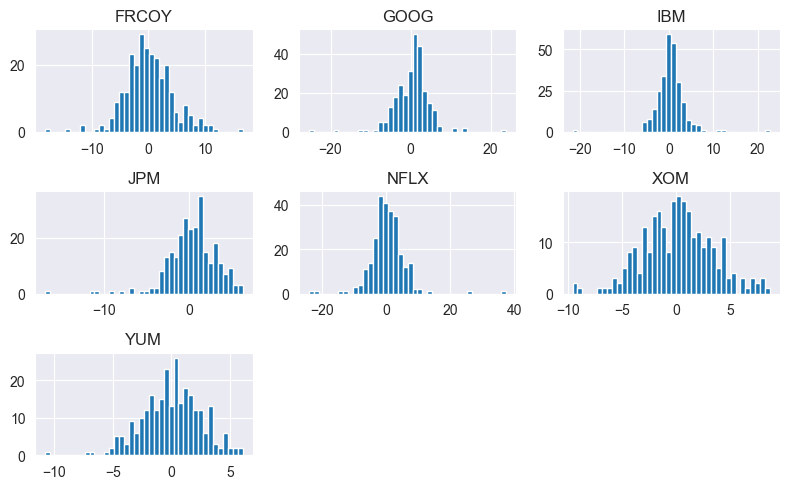

In [13]:
(log_daily_returns*252).hist(figsize = (8,5), bins = 40)
plt.tight_layout()

After this, the Pearson coefficient will be used to explore possible correlations between assets. The pearson coefficient is defined as $$\rho_{XY}= E((X - \mu_X)(Y-\mu_Y))/(\sigma_X \sigma_Y)$$

In [14]:
nc = len(tickers)
rho = np.zeros([nc, nc])
for i in range(nc):
    for j in range(nc):
        muX = np.mean(log_daily_returns.iloc[:,j])
        muY = np.mean(log_daily_returns.iloc[:,i])
        sigmaX = np.std(log_daily_returns.iloc[:,j])
        sigmaY = np.std(log_daily_returns.iloc[:,i])

        rho[j,i] = np.mean( (log_daily_returns.iloc[:,j] - muX)*(log_daily_returns.iloc[:,i] - muY) )/(sigmaX*sigmaY)

rho =  pd.DataFrame(data = rho, columns = tickers, index = tickers )

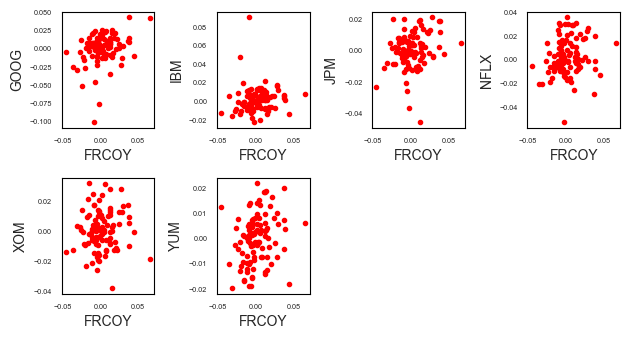

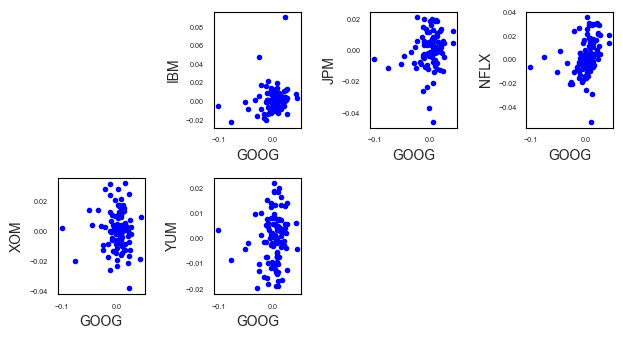

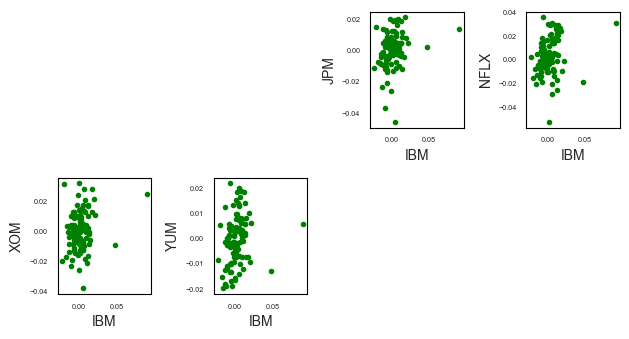

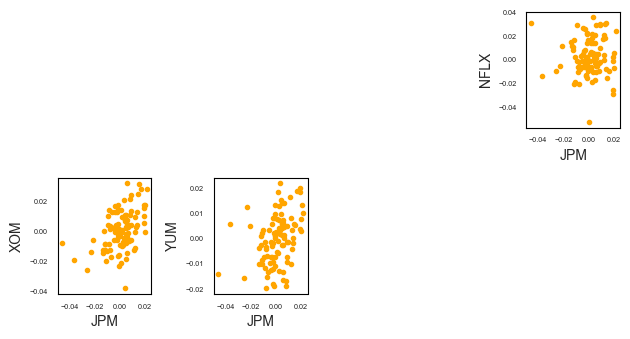

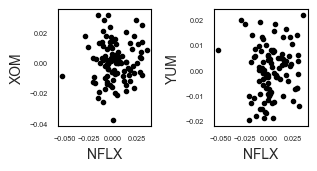

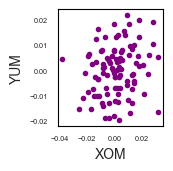

<Figure size 640x480 with 0 Axes>

In [15]:
points = np.random.choice(len(log_daily_returns.iloc[:,0]), 100, replace=False)

nco = 4
nr = 3
color = ['red','blue','green','orange','black','purple','cyan','pink','grey','magenta','red']

for i in range(nc):
    plt.figure()
    for j in range(nc):
        if j>i:
            plt.subplot(nr, nco, j) # (rows, columns, panel number)
            plt.plot(log_daily_returns.iloc[points,i],log_daily_returns.iloc[points,j],'.',color = color[i])
            plt.xlabel(tickers[i])
            plt.ylabel(tickers[j])
            plt.grid(False)
            ax = plt.gca()  
            ax.set_facecolor("white")
            ax.spines[:].set_color("black")
            ax.tick_params(axis = 'both', which = 'major', labelsize = 5.3)
            ax.tick_params(axis = 'both', which = 'minor', labelsize = 5.3)
    
    plt.tight_layout()

In [16]:
print('Correlations between companies log daily returns (Pearson coefficient):')
rho

Correlations between companies log daily returns (Pearson coefficient):


,FRCOY,GOOG,IBM,JPM,NFLX,XOM,YUM
FRCOY,1.000000,0.239478,0.222869,0.214749,0.155581,0.136240,0.238305
GOOG,0.239478,1.000000,0.089862,0.118801,0.284317,-0.105857,0.114120
IBM,0.222869,0.089862,1.000000,0.271838,0.069728,0.096777,0.210088
JPM,0.214749,0.118801,0.271838,1.000000,0.028365,0.288502,0.194624
NFLX,0.155581,0.284317,0.069728,0.028365,1.000000,0.003435,-0.004686
XOM,0.136240,-0.105857,0.096777,0.288502,0.003435,1.000000,0.176177
YUM,0.238305,0.114120,0.210088,0.194624,-0.004686,0.176177,1.000000


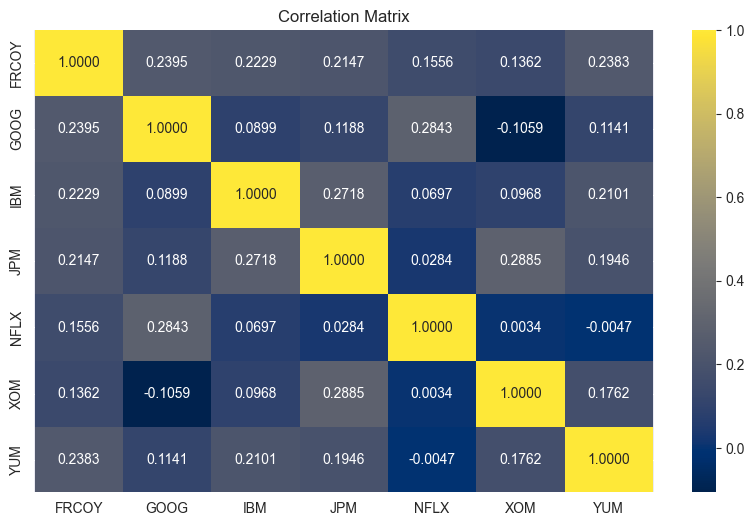

In [17]:
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize = (10,6))
sns.heatmap(rho, annot = True, cmap = 'cividis', fmt ='.4f')
plt.title('Correlation Matrix')

image_name = "source_reports/images/figure_2a_project_1"

plot_margin = 0.01

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))

#plt.savefig(image_name, format=image_format, dpi=image_save_dpi)

plt.show()

The plot below shows the corresponding covariance matrix for the log daily returns.

In [18]:
# Calculate the covariance matrix
covariance_matrix = 252*((log_daily_returns).cov())
print('Covariance matrix log daily returns')

covariance_matrix

Covariance matrix log daily returns


Ticker,FRCOY,GOOG,IBM,JPM,NFLX,XOM,YUM
Ticker,,,,,,,
FRCOY,0.074028,0.018104,0.012358,0.010617,0.014179,0.007552,0.010294
GOOG,0.018104,0.077198,0.005088,0.005998,0.026460,-0.005993,0.005034
IBM,0.012358,0.005088,0.041532,0.010066,0.004760,0.004018,0.006797
JPM,0.010617,0.005998,0.010066,0.033015,0.001726,0.010681,0.005615
NFLX,0.014179,0.026460,0.004760,0.001726,0.112196,0.000234,-0.000249
XOM,0.007552,-0.005993,0.004018,0.010681,0.000234,0.041512,0.005699
YUM,0.010294,0.005034,0.006797,0.005615,-0.000249,0.005699,0.025207


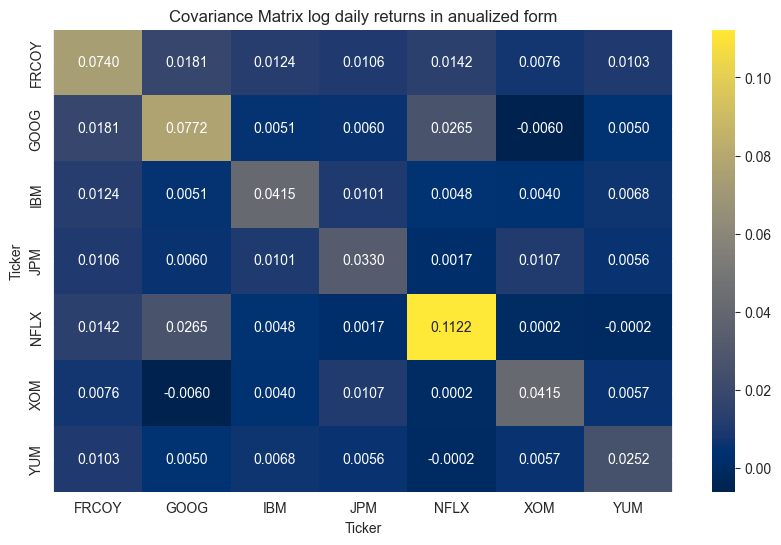

In [19]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (10,6))
sns.heatmap(covariance_matrix, annot = True, cmap = 'cividis', fmt ='.4f')
plt.title('Covariance Matrix log daily returns in anualized form')

image_name = "source_reports/images/figure_2b_project_1"

plot_margin = 0.01

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))

#plt.savefig(image_name, format=image_format, dpi=image_save_dpi)

plt.show()

From the plots and the correlation coefficient matrix is possible to conclude that the candidate companies are not strongly correlated. For this reason we hipothesize that all the candidate companies exhibit diversification, and are suitable to be included in the portfolio.

### Part 2 (A) Lower risk: Portfolio optimization under the criteria of minimizing the portfolio variance

In order to create a portfolio with the lowest risk, I will proceed to find the set $\mathbf{w}$ of asset weights which minimizes the historical portfolio's variance subject to the following constrains:

1. $\sum_i^N w_i = 1$
2. Cannot invest more that 35% of capital into a single asset, this is $w_i < 0.35$.


In [20]:
n_assets = len(tickers)

initial_weights = np.array([1/n_assets] * n_assets)

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

def portfolio_v(weights):
    portfolio_var = portfolio_variance(weights, covariance_matrix)
    return portfolio_var

result = minimize(portfolio_v, initial_weights, constraints = constraints)

optimal_weights = result.x

print("Optimal Asset Weights to minimize variance:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize variance:
FRCOY: Weight = 0.0070
GOOG: Weight = 0.0987
IBM: Weight = 0.1464
JPM: Weight = 0.1670
NFLX: Weight = 0.0701
XOM: Weight = 0.1912
YUM: Weight = 0.3195


In [21]:
daily_returns = np.exp(log_daily_returns) - 1

Now I will proceed to calculate the portfolio variance, expected return, value at risk at the 95% confidence interval, and Sharpe ratio (5% annual):

In [22]:
sigma_V_2 = portfolio_variance(weights = optimal_weights, covariance_matrix = covariance_matrix)
mu_V = portfolio_expected_return(weights = optimal_weights, daily_returns = daily_returns, tickers=tickers)
portfolio_returns = returns(daily_returns = daily_returns, tickers = tickers, weights = optimal_weights)
VaR = calculate_var_95(portfolio_returns)
Sr = sharpe_ratio(mu_v = mu_V, sigma_v = np.sqrt(sigma_V_2), risk_free_rate = 0.05)

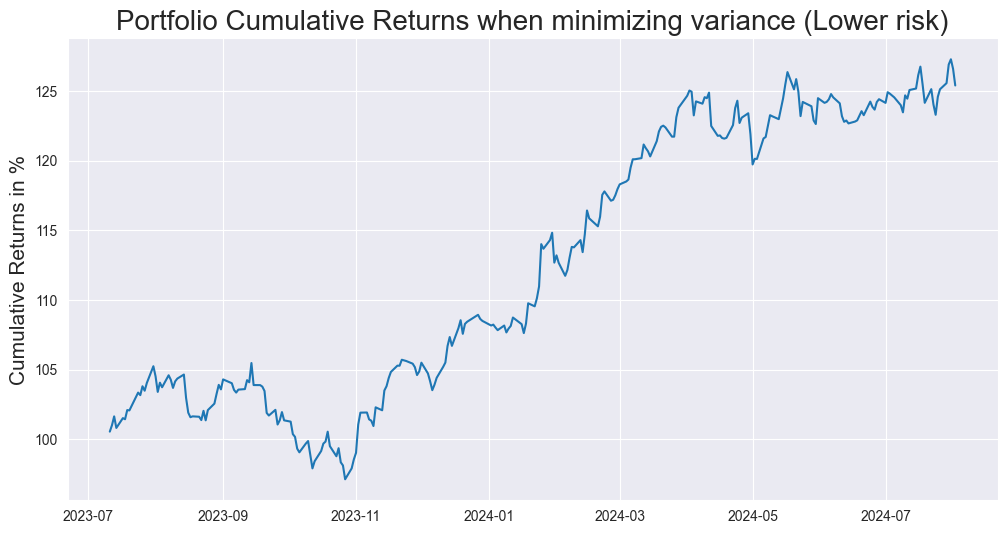

In [23]:
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize = (12,6))

plt.plot(daily_returns.index, cumulative_returns*100)
plt.title('Portfolio Cumulative Returns when minimizing variance (Lower risk)', size = 20)
plt.ylabel('Cumulative Returns in %', fontsize = 15)

plt.show()

In [24]:
print(f"Portfolio Sharpe Ratio: {Sr:.4f}")
print('---------')
print(f"Portfolio Volatility: {np.sqrt(sigma_V_2)}")
print('-------')
print(f"Portfolio annualized Expected return: {100*mu_V:.4f}%")
print('-------')
print(f"Portfolio Return: {100*cumulative_returns[-1]:.4f}%")
print('-------')
print(f"Portfolio Value at risk: {VaR}%")

Portfolio Sharpe Ratio: 1.5573
---------
Portfolio Volatility: 0.10785297207902142
-------
Portfolio annualized Expected return: 21.7955%
-------
Portfolio Return: 125.4051%
-------
Portfolio Value at risk: -1.0323877825950125%


### Part 2 (B): Portfolio optimization under the criteria of maximizing the portfolio risk adjustment performance (Sharpe ratio)

Monte Carlo simulation will be performed for finding a portfolio in which is maximized the Sharpe ratio. I will calculate random sets of portfolio investment percentages (asset weights) $w_i$, $i \in 1,\cdots, N$, where $N = 7$, with  similar constrains from (part 2A).

For each set of assets weights $\mathbf{w}$, will be calculated the main metrics for the portfolio.

In [25]:
n_samples = 10000
nc = len(tickers)
W = np.zeros((n_samples, nc))
MU = np.zeros(n_samples)
SI = np.zeros(n_samples)
SR = np.zeros(n_samples)
VAR = np.zeros(n_samples)

for i in range(n_samples):
    w = np.random.uniform(low = 0, high = 0.35, size = nc)
    w = w/np.sum(w)
    W[i,:] = w
    MU[i] = portfolio_expected_return(weights = w, daily_returns=daily_returns, tickers=tickers)
    SI[i] = portfolio_variance(weights= w, covariance_matrix=covariance_matrix)
    SR[i] = sharpe_ratio(mu_v =  MU[i], sigma_v = np.sqrt(SI[i]), risk_free_rate = 0.05 )
    portfolio_returns = returns(daily_returns = daily_returns, tickers=tickers, weights=w)
    VAR[i] = calculate_var_95(portfolio_returns)

First I generate an approximation of the minimum of the portfolio variance (Item 2A) via Monte Carlo simulation to compare with previous results:

In [26]:
ind1 = SI.argmin()

print(f"Portfolio Sharpe Ratio: {SR[ind1]:.4f}")
print('---------')
print(f"Portfolio Volatility: {np.sqrt(SI[ind1])}")
print('-------')
print(f"Portfolio annualized Expected return: {100*MU[ind1]:.4f}%")
print('-------')
print(f"Portfolio Value at risk: {VAR[ind1]}%")

Portfolio Sharpe Ratio: 1.7152
---------
Portfolio Volatility: 0.10918743443131318
-------
Portfolio annualized Expected return: 23.7281%
-------
Portfolio Value at risk: -1.0201844192905445%


Now I estimate the maximum value of the Sharpe ratio for the portfolio.

In [27]:
ind = SR.argmax()
print(f"Portfolio Sharpe Ratio: {SR[ind]:.4f}")
print('---------')
print(f"Portfolio Volatility: {np.sqrt(SI[ind])}")
print('-------')
print(f"Portfolio annualized Expected return: {100*MU[ind]:.4f}%")
print('-------')
print(f"Portfolio Value at risk: {VAR[ind]}%")

metrics = np.array( [  [SR[ind1], np.sqrt(SI[ind1]), 100*MU[ind1],  VAR[ind1] ],
       [SR[ind], np.sqrt(SI[ind]), 100*MU[ind],  VAR[ind]] ])

metrics = pd.DataFrame(metrics)
metrics.columns = ["Sharpe Ratio", "Volatility", "Annualized Expected return (perc)", "Value at risk (perc)"]
metrics.index = ["Lower risk","Higher risk"]
metrics.to_csv('source_reports/images/metrics.csv')

Portfolio Sharpe Ratio: 2.2388
---------
Portfolio Volatility: 0.12854424629263475
-------
Portfolio annualized Expected return: 33.7784%
-------
Portfolio Value at risk: -1.263192497106099%


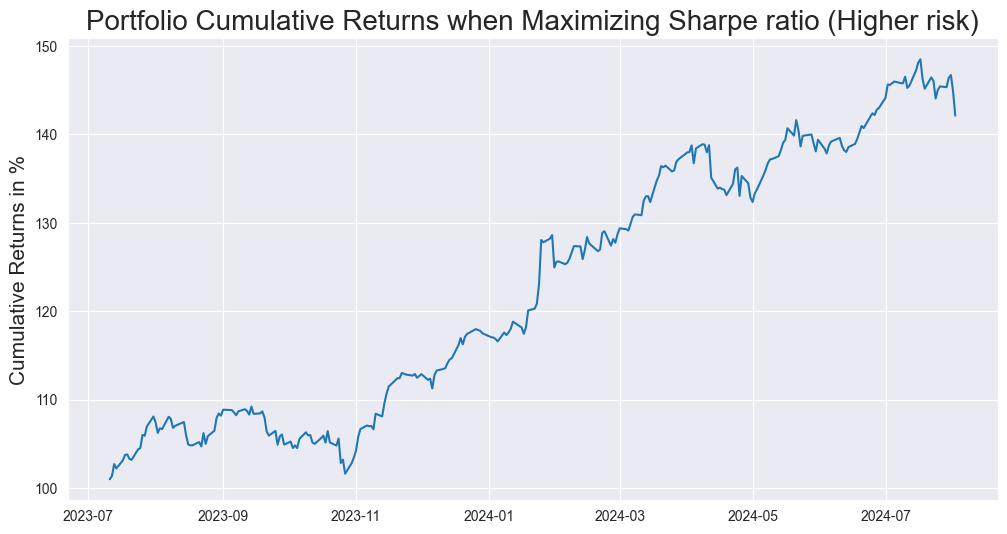

In [28]:
portfolio_returns = returns(daily_returns = daily_returns, tickers = tickers, weights = W[ind, ])
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize = (12, 6))

plt.plot(daily_returns.index, cumulative_returns*100)
plt.title('Portfolio Cumulative Returns when Maximizing Sharpe ratio (Higher risk)', size = 20)
plt.ylabel('Cumulative Returns in %', fontsize = 15)

plt.show()

Below I proceed to show the visualization of the expected return $\mu_V$ and the volatility $\sigma_V$ for the portfolio. The black dot corresponds to the values that maximize the Sharpe ratio. The green point corresponds to the values that minimize the variance (2A). 

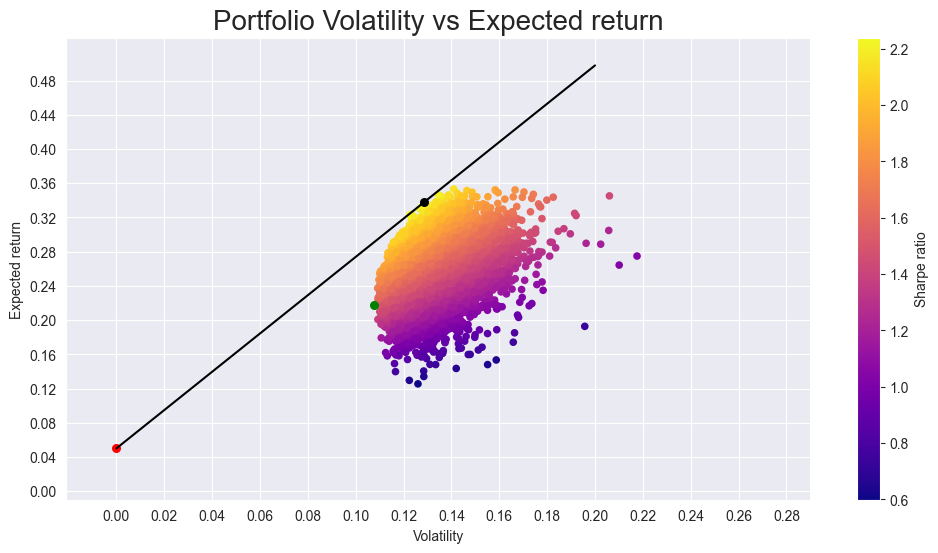

In [29]:
plt.figure(figsize= (12,6))
plt.scatter(np.sqrt(SI), MU, c = SR, cmap = 'plasma', s = 20)
plt.colorbar(label = "Sharpe ratio")
plt.xlabel("Volatility")
plt.ylabel("Expected return")
plt.title('Portfolio Volatility vs Expected return', size = 20)

sc = (MU[ind] - 0.05)/(np.sqrt(SI[ind]) - 0)
y = sc*0.2 + 0.05
plt.plot([0, 0.2], [0.05, y], 'k-')
plt.scatter(np.sqrt(SI[ind]), MU[ind], c = "black", s=30)
plt.scatter(np.sqrt(sigma_V_2), mu_V, c = "green", s=30)
plt.scatter(0, 0.05, c = "red", s=30)
plt.xticks(np.arange(0, 0.3, 0.02))
plt.yticks(np.arange(0, 0.5, 0.04))

image_name = "source_reports/images/figure_3_project_1"

plot_margin = 0.01

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))

#plt.savefig(image_name, format=image_format, dpi=image_save_dpi)

plt.show()

## Results

We selected seven companies from diverse sectors that did not exhibit strong correlations. 


(LOWER RISK) The portfolio with the lower risk was calculated by using the criteria of the minimum variance. The assets allocations for the case are 

In [30]:
for k in range(nc):
    print(f'{optimal_weights[k]*100 :.3f}% for {names_companies[k]}')

0.701% for Fast Retailing Co., Ltd.
9.868% for Alphabet Inc.
14.641% for International Business Machines Corporation
16.699% for JPMorgan Chase & Co.
7.013% for Netflix, Inc.
19.124% for Exxon Mobil Corporation
31.953% for Yum! Brands, Inc.


(HIGHER RISK) The portfolio with higher risk was calculated by using the criteria of the maximum Sharpe ratio. The assets allocations for the case are

In [31]:
optimal_weights2 = W[ind,:]
for k in range(nc):
    print(f'{optimal_weights2[k]*100 :.3f}% for {names_companies[k]}')

optimal = pd.DataFrame(columns=['Lower risk (perc)', 'Higher risk (perc)'], index = names_companies )
optimal.iloc[:,0]=optimal_weights*100
optimal.iloc[:,1]=optimal_weights2*100
optimal.to_csv('source_reports/images/optimal.csv')


0.501% for Fast Retailing Co., Ltd.
23.955% for Alphabet Inc.
25.697% for International Business Machines Corporation
25.037% for JPMorgan Chase & Co.
10.955% for Netflix, Inc.
13.494% for Exxon Mobil Corporation
0.362% for Yum! Brands, Inc.


We observed that the point in which the volatility has the lowest value (green dot) is located at the lowest x-axis coordinate of the Monte Carlo simulated points (Volatily). Also notice that the Sharpe ratio that has the maximum value (black dot) belongs to the tangencial line from the risk free rate at zero (Red dot). The previous observations show the expected behaviour stated by the efficient portfolio frontier [1].

[1] Capiński, M., & Zastawniak, T. (2014). Mathematics for finance: An introduction to financial engineering. Springer. 